In [ ]:
# pyright: reportUnusedExpression=false

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson, skellam

In [ ]:
from math import ceil
from typing import Tuple

# [CDAF] Atividade 1

## Nome e matrícula
Nome: Igor Lacerda Faria da Silva
Matrícula: 2020041973

## Introdução
Nesta atividade, vamos revisar os conceitos aprendidos em sala de aula sobre aleatoriedade e previsão, trabalhando em cima do dataset do Soccer Prediction Challenge, disponível no Moodle.

## Questão 1
- Carregue o dataset 'TrainingSet_2023_02_08'
- Crie um histograma para a quantidade de gols marcados por jogo do time da casa, do time fora, de gols totais e da diferença de gols por partida.
- Caso hajam instâncias com valores nitidamente errados, destaque-os e remova-os antes de gerar os histogramas.
- Calcule o mínimo, o máximo e a média de cada um dos 4 histogramas solicitados acima.

In [ ]:
df = pd.read_excel("TrainingSet_2023_02_08.xlsx")

In [1]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299214 entries, 0 to 299213
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Sea     299214 non-null  object
 1   Lge     299214 non-null  object
 2   Date    299214 non-null  object
 3   HT      299214 non-null  object
 4   AT      299214 non-null  object
 5   HS      299214 non-null  int64 
 6   AS      299214 non-null  int64 
 7   GD      299214 non-null  int64 
 8   WDL     299214 non-null  object
dtypes: int64(3), object(6)
memory usage: 20.5+ MB


In [2]:
df.head()

     Sea   Lge        Date              HT             AT   HS   AS  GD WDL  total
0  00-01  GER1  11/08/2000        Dortmund  Hansa Rostock  1.0  0.0   1   W    1.0
1  00-01  GER1  12/08/2000   Bayern Munich  Hertha Berlin  4.0  1.0   3   W    5.0
2  00-01  GER1  12/08/2000        Freiburg  VfB Stuttgart  4.0  0.0   4   W    4.0
3  00-01  GER1  12/08/2000    Hamburger SV    Munich 1860  2.0  2.0   0   D    4.0
4  00-01  GER1  12/08/2000  Kaiserslautern         Bochum  0.0  1.0  -1   L    1.0

In [ ]:
def histogram(column: pd.Series):
    mean, min, max = column.mean(), column.min(), column.max()
    bins = np.arange(min, max + 1, 1)
    plt.hist(column, align="left", bins=bins)
    plt.xticks(bins)
    plt.title(column.name)
    plt.axvline(mean, color="k", linestyle="dashed", linewidth=1)
    plt.axvline(min, color="r", linestyle="dashed", linewidth=1)
    plt.axvline(max, color="r", linestyle="dashed", linewidth=1)
    plt.show()
    print(f"Média: {mean}   Mínimo: {min}   Máximo: {max}")

In [ ]:
# Tirando -1, como alguém faz gol negativo?
df["HS"] = df.query("HS > -1")["HS"]
df["AS"] = df.query("AS > -1")["AS"]

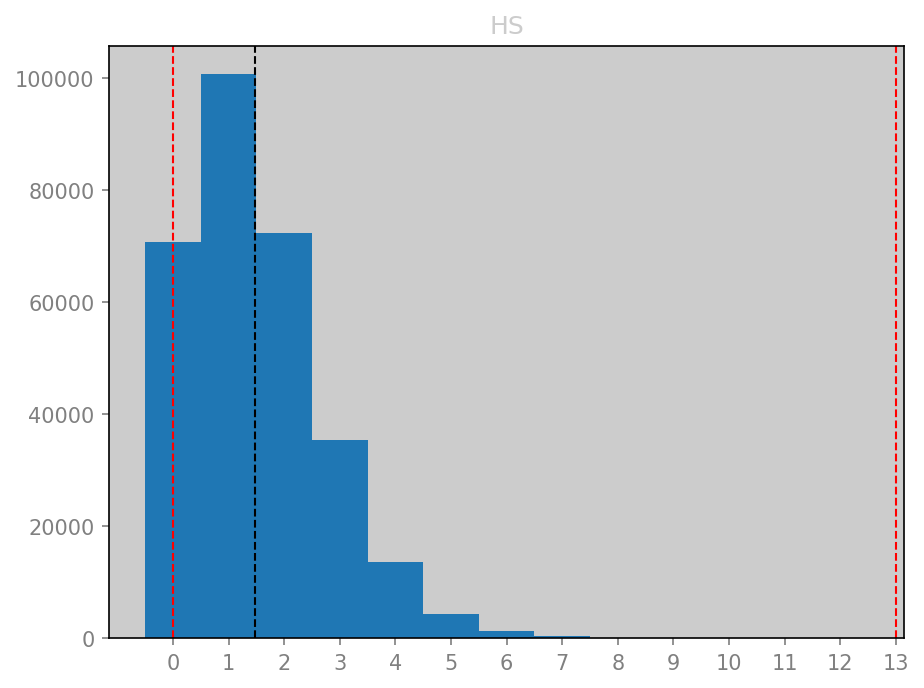


Média: 1.471700194179949   Mínimo: 0.0   Máximo: 13.0


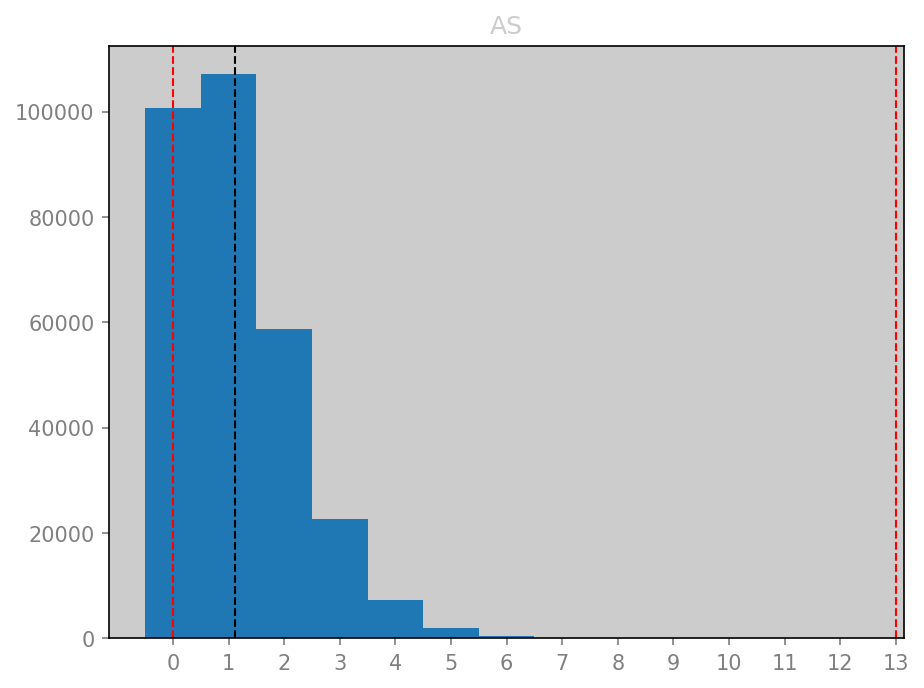


Média: 1.1214410090673013   Mínimo: 0.0   Máximo: 13.0


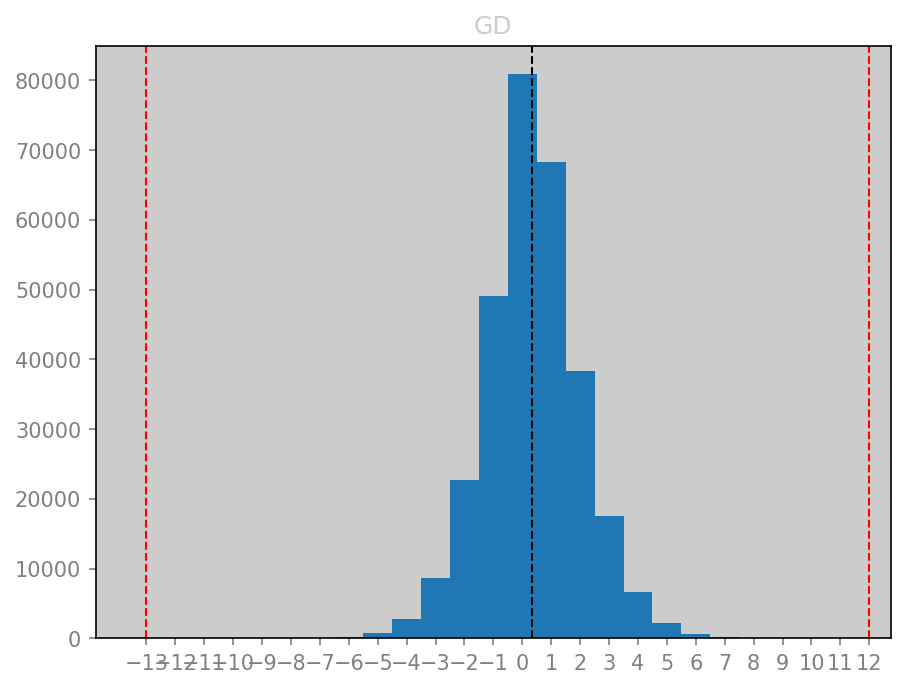


Média: 0.3502509909295688   Mínimo: -13   Máximo: 12


In [3]:
# Home, Adversary, Diference
for column in ["HS", "AS", "GD"]:
    histogram(df[column])

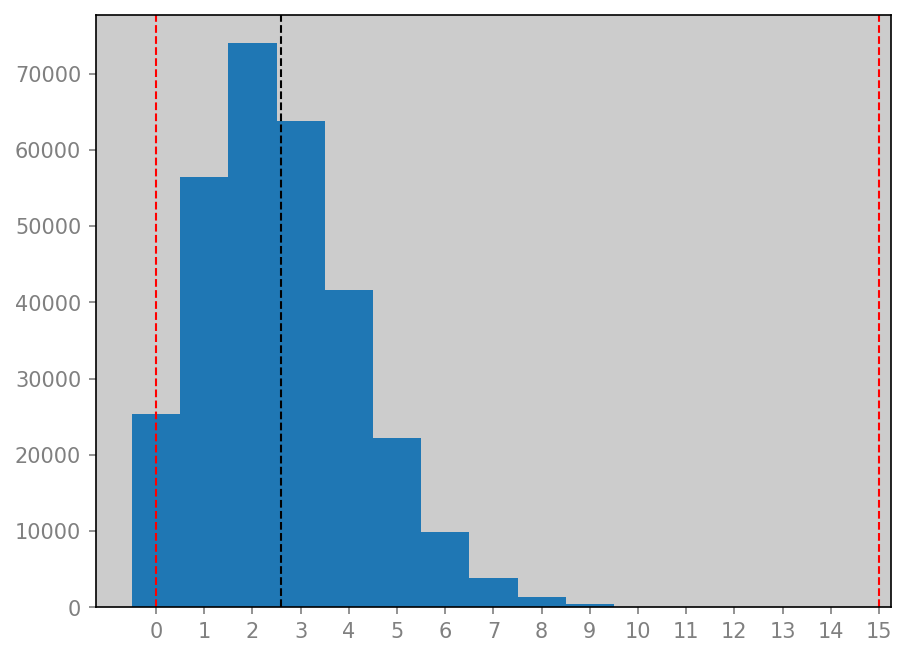


Média: 2.5931412032472503   Mínimo: 0.0   Máximo: 15.0


In [4]:
# Total
histogram(abs(df["AS"]) + abs(df["HS"]))

## Questão 2
- Escolha uma temporada que já terminou, de alguma das ligas presentes no dataset.
- Realize os mesmos histogramas da questão 1, mas agora para a temporada escolhida.
- Quais as diferenças entre os histogramas da questão 1 e da questão 2? O que isso pode indicar sobre a qualidade ofensiva da liga escolhida vs. o todo?

In [ ]:
LEAGUE = "GER1"
SEASON = "00-01"

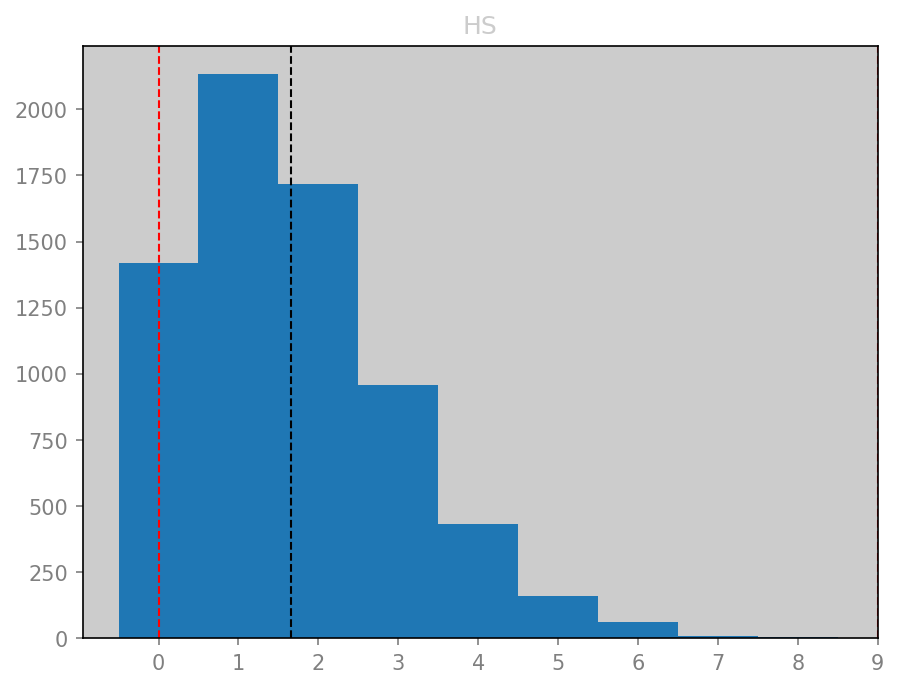


Média: 1.663479646530494   Mínimo: 0.0   Máximo: 9.0


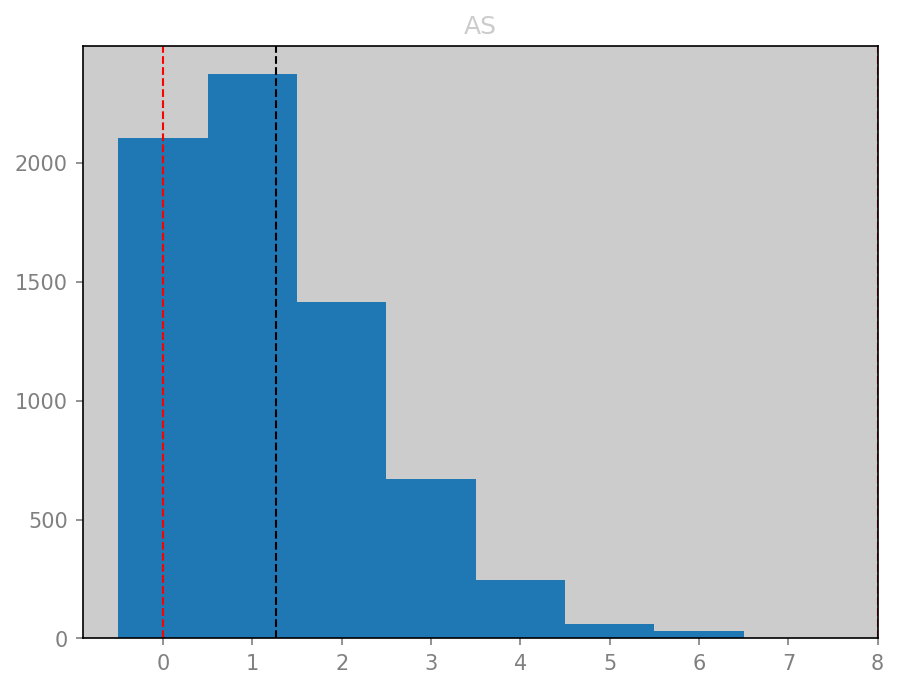


Média: 1.2623497030276691   Mínimo: 0.0   Máximo: 8.0


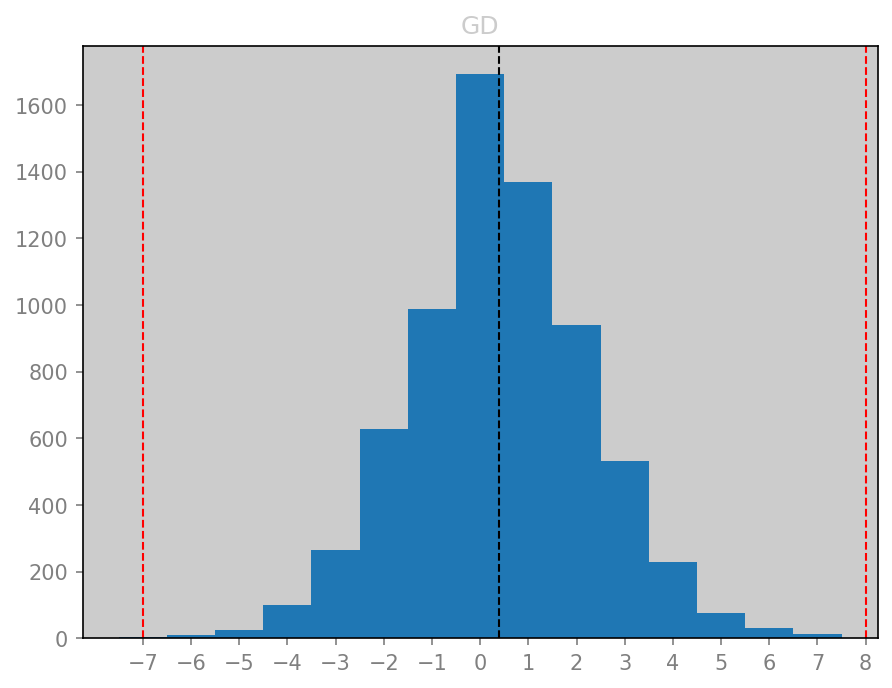


Média: 0.4011299435028249   Mínimo: -7   Máximo: 8


In [5]:
for column in ["HS", "AS", "GD"]:
    histogram(df.query(f"Lge == '{LEAGUE}'")[column])

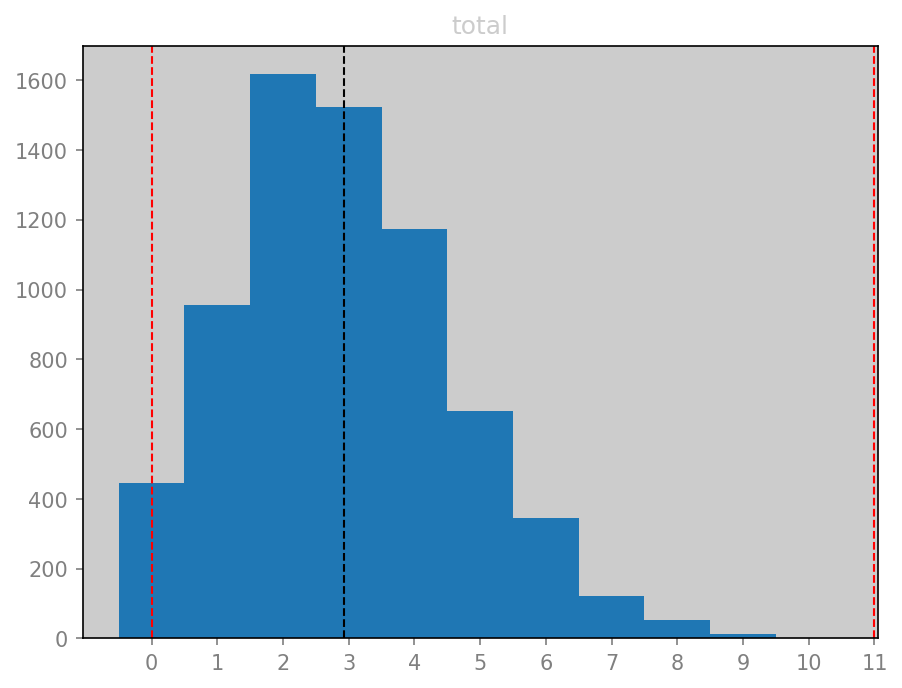


Média: 2.925829349558163   Mínimo: 0.0   Máximo: 11.0


In [6]:
df["total"] = abs(df["AS"]) + abs(df["HS"])
histogram(df.query(f"Lge == '{LEAGUE}'")["total"])

Em média, na liga GER1, são feitos mais gols, em comparação com o total.

## Questão 3
- À partir dos dados do campeonato em selecionado, crie um dataframe que corresponda à tabela de classificação ao fim da temporada contendo o nome dos times, nº de pontos, jogos, vitórias, empates, derrotas, gols pró, gols contra e saldo de gols. Ordena a classificação por pontos, vitórias, saldo de gols e gols pró.
- Faça o mesmo para apenas para a primeira metade de jogos.

In [ ]:
def get_table(df: pd.DataFrame, league: str, season: str, ratio: float) -> pd.DataFrame:
    df_league = df
    if "Lge" in df:
        df_league = df.query(f"Lge == '{league}' and Sea == '{season}'")
    teams = df_league["HT"].unique()
    data: list[list] = []
    for team in teams:
        df_team: pd.DataFrame = df_league.query(f"HT == '{team}' or AT == '{team}'")
        if "Date" in df_team:
            df_team.sort_values(by=["Date"])
        played = ceil(ratio * len(df_team))

        # Ajusta dataframe para representar a porção mais recente dos jogos jogados pelo time
        df_team = df_team.head(played)

        won = len(
            df_team.query(
                f"(HT == '{team}' and WDL == 'W') or (AT == '{team}' and WDL == 'L')"
            )
        )
        drawn = len(
            df_team.query(
                f"(HT == '{team}' and WDL == 'D') or (AT == '{team}' and WDL == 'D')"
            )
        )
        lost = len(
            df_team.query(
                f"(HT == '{team}' and WDL == 'L') or (AT == '{team}' and WDL == 'W')"
            )
        )

        assert played == won + drawn + lost

        points = 3 * won + drawn

        gf = sum(df_team.query(f"HT == '{team}'")["HS"]) + sum(
            df_team.query(f"AT == '{team}'")["AS"]
        )
        ga = sum(df_team.query(f"HT == '{team}'")["AS"]) + sum(
            df_team.query(f"AT == '{team}'")["HS"]
        )
        gd = gf - ga

        data.append([team, played, won, drawn, lost, gf, ga, gd, points])

    df_table = pd.DataFrame(
        data,
        columns=["Team", "Matches", "Won", "Drawn", "Lost", "GF", "GA", "GD", "Points"],
    )
    df_table = df_table.sort_values(by=["Points", "Won", "GD", "GF"], ascending=False)
    return df_table

In [7]:
# Primeiro: Bayern Munich, Quarto: Leverkusen
df_full_table = get_table(df, LEAGUE, SEASON, 1)
df_full_table

                   Team  Matches  Won  Drawn  Lost    GF    GA    GD  Points
1         Bayern Munich       34   19      6     9  62.0  37.0  25.0      63
8            Schalke 04       34   18      8     8  65.0  35.0  30.0      62
0              Dortmund       34   16     10     8  62.0  42.0  20.0      58
5            Leverkusen       34   17      6    11  54.0  40.0  14.0      57
12        Hertha Berlin       34   18      2    14  58.0  52.0   6.0      56
2              Freiburg       34   15     10     9  54.0  37.0  17.0      55
6         Werder Bremen       34   15      8    11  53.0  48.0   5.0      53
4        Kaiserslautern       34   15      5    14  49.0  54.0  -5.0      50
15            Wolfsburg       34   12     11    11  60.0  45.0  15.0      47
16              FC Koln       34   12     10    12  59.0  52.0   7.0      46
10          Munich 1860       34   12      8    14  43.0  55.0 -12.0      44
17        Hansa Rostock       34   12      7    15  34.0  47.0 -13.0      43

In [8]:
# Apenas para a primeira metade dos jogos
df_half = get_table(df, LEAGUE, SEASON, 0.5)
df_half

                   Team  Matches  Won  Drawn  Lost    GF    GA    GD  Points
8            Schalke 04       17   10      3     4  46.0  17.0  29.0      33
5            Leverkusen       17    9      4     4  39.0  19.0  20.0      31
1         Bayern Munich       17    9      3     5  49.0  19.0  30.0      30
0              Dortmund       17    9      3     5  40.0  24.0  16.0      30
12        Hertha Berlin       17    9      1     7  45.0  31.0  14.0      28
4        Kaiserslautern       17    8      3     6  37.0  23.0  14.0      27
16              FC Koln       17    7      4     6  50.0  27.0  23.0      25
15            Wolfsburg       17    6      6     5  45.0  24.0  21.0      24
2              Freiburg       17    6      5     6  35.0  21.0  14.0      23
3          Hamburger SV       17    6      3     8  43.0  32.0  11.0      21
17        Hansa Rostock       17    6      3     8  22.0  27.0  -5.0      21
10          Munich 1860       17    5      6     6  30.0  30.0   0.0      21

In [9]:
df_half.head()

             Team  Matches  Won  Drawn  Lost    GF    GA    GD  Points
8      Schalke 04       17   10      3     4  46.0  17.0  29.0      33
5      Leverkusen       17    9      4     4  39.0  19.0  20.0      31
1   Bayern Munich       17    9      3     5  49.0  19.0  30.0      30
0        Dortmund       17    9      3     5  40.0  24.0  16.0      30
12  Hertha Berlin       17    9      1     7  45.0  31.0  14.0      28

## Questão 4
- Utilizando os jogos da liga escolhida, use regressão de Poisson para criar um modelo de previsão de resultados, como visto nos slides em sala e no Soccermatics.
-- https://soccermatics.readthedocs.io/en/latest/gallery/lesson5/plot_SimulateMatches.html
- Dê print no sumário do ajuste
- Simule a partida entre o 1º e o 4º colocado, onde o 1º joga em casa. Primeiro, apresente a quantidade esperada de gols de cada time. Em seguida, apresente um histograma com a probabilidade de diferentes placares entre os times.

In [10]:
df_sample = df.query(f"Lge == '{LEAGUE}' and Sea == '{SEASON}'")
df_sample

       Sea   Lge        Date              HT             AT   HS   AS  GD WDL  total
0    00-01  GER1  11/08/2000        Dortmund  Hansa Rostock  1.0  0.0   1   W    1.0
1    00-01  GER1  12/08/2000   Bayern Munich  Hertha Berlin  4.0  1.0   3   W    5.0
2    00-01  GER1  12/08/2000        Freiburg  VfB Stuttgart  4.0  0.0   4   W    4.0
3    00-01  GER1  12/08/2000    Hamburger SV    Munich 1860  2.0  2.0   0   D    4.0
4    00-01  GER1  12/08/2000  Kaiserslautern         Bochum  0.0  1.0  -1   L    1.0
..     ...   ...         ...             ...            ...  ...  ...  ..  ..    ...
301  00-01  GER1  19/05/2001    Hamburger SV  Bayern Munich  1.0  1.0   0   D    2.0
302  00-01  GER1  19/05/2001  Kaiserslautern  Hertha Berlin  0.0  1.0  -1   L    1.0
303  00-01  GER1  19/05/2001      Leverkusen         Bochum  1.0  0.0   1   W    1.0
304  00-01  GER1  19/05/2001      Schalke 04   Unterhaching  5.0  3.0   2   W    8.0
305  00-01  GER1  19/05/2001   Werder Bremen  Hansa Rostock  3.0 

In [11]:
goal_model_data = pd.concat(
    [
        df_sample[["HT", "AT", "HS"]]
        .assign(home=1)
        .rename(columns={"HT": "team", "AT": "opponent", "HS": "goals"}),
        df_sample[["AT", "HT", "AS"]]
        .assign(home=0)
        .rename(columns={"AT": "team", "HT": "opponent", "AS": "goals"}),
    ]
)

poisson_model = smf.glm(
    formula="goals ~ home + team + opponent",
    data=goal_model_data,
    family=sm.families.Poisson(),
).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  612
Model:                            GLM   Df Residuals:                      576
Model Family:                 Poisson   Df Model:                           35
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -918.48
Date:                Sun, 09 Apr 2023   Deviance:                       724.18
Time:                        22:10:06   Pearson chi2:                     634.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1670
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [ ]:
def get_teams(pos: Tuple[int, int], table: pd.DataFrame) -> Tuple[str, str]:
    return table.iloc[[pos[0]]]["Team"].item(), table.iloc[[pos[1]]]["Team"].item()

In [12]:
home_team, away_team = get_teams((0, 3), df_full_table)
home_team, away_team

('Bayern Munich', 'Leverkusen')

In [ ]:
def predict_match(home_team: str, away_team: str, verbose: bool):
    home_score_rate = poisson_model.predict(
        pd.DataFrame(
            data={"team": home_team, "opponent": away_team, "home": 1}, index=[1]
        )
    )
    away_score_rate = poisson_model.predict(
        pd.DataFrame(
            data={"team": away_team, "opponent": home_team, "home": 0}, index=[1]
        )
    )
    if verbose:
        print(
            home_team
            + " against "
            + away_team
            + " expect to score: "
            + str(home_score_rate)
        )
        print(
            away_team
            + " against "
            + home_team
            + " expect to score: "
            + str(away_score_rate)
        )

    # Lets just get a result
    home_goals = np.random.poisson(home_score_rate)
    away_goals = np.random.poisson(away_score_rate)
    home_result = home_goals[0]
    away_result = away_goals[0]
    # home_state = "W" if home_result > away_result else "L"
    # if home_result == away_result:
    #     home_state = "D"
    home_state = None
    if float(home_score_rate) - float(away_score_rate) > 0.5:
        home_state = "W"
    elif float(home_score_rate) - float(away_score_rate) < -0.5:
        home_state = "L"
    else:
        home_state = "D"

    if verbose:
        print(home_team + ": " + str(home_result))
        print(away_team + ": " + str(away_result))

    return [home_team, away_team, home_result, away_result, home_state]

In [13]:
predict_match(home_team, away_team, True)

Bayern Munich against Leverkusen expect to score: 1    1.753296
dtype: float64
Leverkusen against Bayern Munich expect to score: 1    0.936653
dtype: float64
Bayern Munich: 2
Leverkusen: 1


['Bayern Munich', 'Leverkusen', 2, 1, 'W']

In [ ]:
# Code to caluclate the goals for the match.
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(
        pd.DataFrame(
            data={"team": homeTeam, "opponent": awayTeam, "home": 1}, index=[1]
        )
    ).values[0]
    away_goals_avg = foot_model.predict(
        pd.DataFrame(
            data={"team": awayTeam, "opponent": homeTeam, "home": 0}, index=[1]
        )
    ).values[0]
    team_pred = [
        [poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)]
        for team_avg in [home_goals_avg, away_goals_avg]
    ]
    return np.outer(np.array(team_pred[0]), np.array(team_pred[1]))


def match_histogram(poisson_model, home_team: str, away_team: str):
    # Fill in the matrix
    max_goals = 5
    score_matrix = simulate_match(poisson_model, home_team, away_team, max_goals)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    pos = ax.imshow(
        score_matrix,
        extent=[-0.5, max_goals + 0.5, -0.5, max_goals + 0.5],
        aspect="auto",
        cmap=plt.cm.Reds,
    )
    fig.colorbar(pos, ax=ax)
    ax.set_title("Probability of outcome")
    plt.xlim((-0.5, 5.5))
    plt.ylim((-0.5, 5.5))
    plt.tight_layout()
    ax.set_xlabel("Goals scored by " + away_team)
    ax.set_ylabel("Goals scored by " + home_team)
    plt.show()

    # Home, draw, away probabilities
    homewin = np.sum(np.tril(score_matrix, -1))
    draw = np.sum(np.diag(score_matrix))
    awaywin = np.sum(np.triu(score_matrix, 1))

    return (homewin, draw, awaywin)

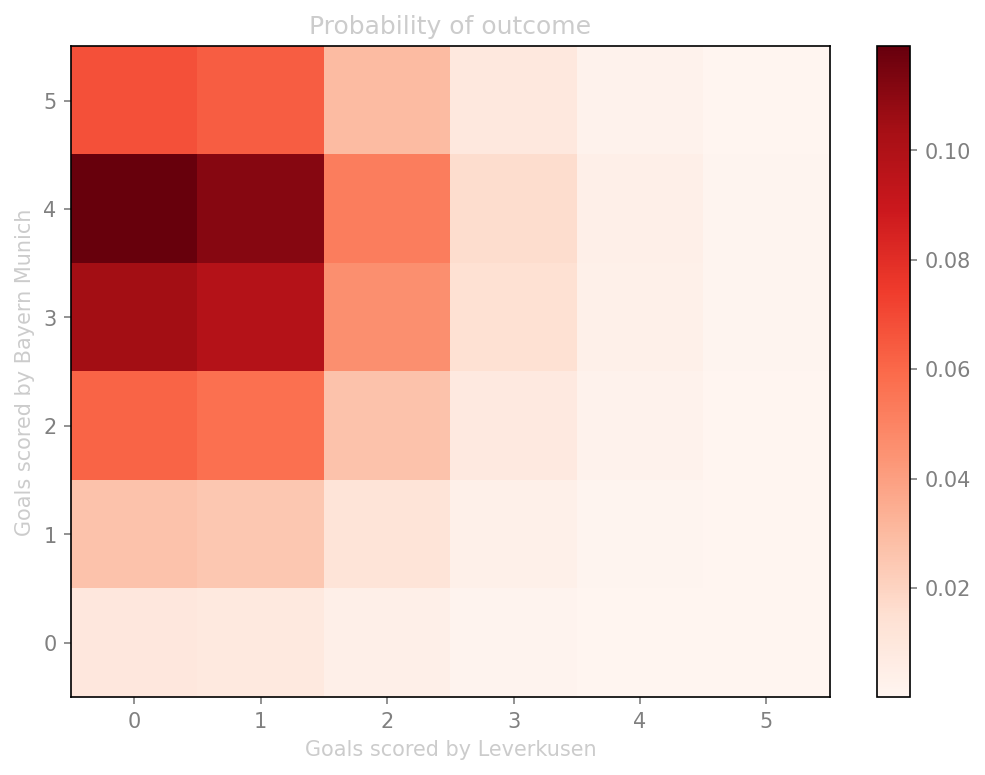

(0.5569346601684995, 0.23440095655136858, 0.19903294131326035)

In [14]:
match_histogram(poisson_model, home_team, away_team)

## Questão 5
- Utilize o modelo treinado para simular os placares esperados de todos os jogos da temporada.
- Construa uma tabela de classificação em cima dos resultados esperados. Considere que jogos com uma diferença esperada de gols < 0.5 é um empate.
- Compare a tabela real com a simulada. Onde estão as principais diferenças entre elas? E similaridades? O que isso pode indicar em termos de o que modelo subestima e superestima sobre a qualidade dos times?

In [ ]:
def get_table_adjusted(df: pd.DataFrame, league: str, season: str):
    teams = df["HT"].unique()
    data: list[list] = []
    for team in teams:
        df_team: pd.DataFrame = df.query(f"HT == '{team}' or AT == '{team}'")
        played = len(df_team)

        won = len(
            df_team.query(
                f"(HT == '{team}' and WDL == 'W') or (AT == '{team}' and WDL == 'L')"
            )
        )
        drawn = len(
            df_team.query(
                f"(HT == '{team}' and WDL == 'D') or (AT == '{team}' and WDL == 'D')"
            )
        )
        lost = len(
            df_team.query(
                f"(HT == '{team}' and WDL == 'L') or (AT == '{team}' and WDL == 'W')"
            )
        )

        assert played == won + drawn + lost

        points = 3 * won + drawn

        data.append([team, played, won, drawn, lost, points])

    df_table = pd.DataFrame(
        data,
        columns=["Team", "Matches", "Won", "Drawn", "Lost", "Points"],
    )
    df_table = df_table.sort_values(by=["Points", "Won"], ascending=False)
    return df_table

In [ ]:
def championship(league: str, season: str):
    data: list[list] = []
    df_league = df.query(f"Lge == '{league}' and Sea == '{season}'")
    teams = df_league["HT"].unique()
    for x in teams:
        for y in teams:
            if x != y:
                match = predict_match(x, y, False)
                data.append(match)
    df_simulation_games = pd.DataFrame(
        data,
        columns=["HT", "AT", "HS", "AS", "WDL"],
    )
    return get_table_adjusted(df_simulation_games, league, season)

In [ ]:
df_table_simulation = championship(LEAGUE, SEASON)

In [ ]:
# df_table_simulation.to_csv("simulation.csv", index=False)

In [15]:
df_table_simulation

                   Team  Matches  Won  Drawn  Lost  Points
8            Schalke 04       34   23     11     0      80
1         Bayern Munich       34   19     14     1      71
2              Freiburg       34   18     13     3      67
0              Dortmund       34   18     12     4      66
15            Wolfsburg       34   16     13     5      61
5            Leverkusen       34   14     15     5      57
6         Werder Bremen       34   12     13     9      49
12        Hertha Berlin       34   12     13     9      49
16              FC Koln       34   12     13     9      49
3          Hamburger SV       34   12     12    10      48
4        Kaiserslautern       34    8     16    10      40
13        VfB Stuttgart       34    6     17    11      35
10          Munich 1860       34    5     16    13      31
9       Energie Cottbus       34    3     17    14      26
17        Hansa Rostock       34    3     17    14      26
14         Unterhaching       34    2     12    20      

In [16]:
# df_full_table.to_csv("real.csv", index=False)
df_full_table

                   Team  Matches  Won  Drawn  Lost    GF    GA    GD  Points
1         Bayern Munich       34   19      6     9  62.0  37.0  25.0      63
8            Schalke 04       34   18      8     8  65.0  35.0  30.0      62
0              Dortmund       34   16     10     8  62.0  42.0  20.0      58
5            Leverkusen       34   17      6    11  54.0  40.0  14.0      57
12        Hertha Berlin       34   18      2    14  58.0  52.0   6.0      56
2              Freiburg       34   15     10     9  54.0  37.0  17.0      55
6         Werder Bremen       34   15      8    11  53.0  48.0   5.0      53
4        Kaiserslautern       34   15      5    14  49.0  54.0  -5.0      50
15            Wolfsburg       34   12     11    11  60.0  45.0  15.0      47
16              FC Koln       34   12     10    12  59.0  52.0   7.0      46
10          Munich 1860       34   12      8    14  43.0  55.0 -12.0      44
17        Hansa Rostock       34   12      7    15  34.0  47.0 -13.0      43

## Comparação

Gerando algumas simulações, é possível perceber que o modelo tende a exagerar os extremos. Isso fica expecialmente claro ao se olhar a tabela de pontos: existem casos em que o primeiro time fica com 80 pontos e o último com 8 (quando, na realidade, essa variação fica faixa 63-27). Também é possível perceber essa discrepância ao se notar que o conjunto os times extremos se mantém, enquanto há maior variabilidade nos times mais próximos da média. Isto é, o mesmo conjunto de 4 times vencedores (ou perdedores) se mantém, e a ordem outros muda em maior intensidade. No entanto, essa análise é rasa, seria necessário aplicar métodos estatísticos para se ter uma ideia da real efetividade do modelo. Por exemplo, seria possível gerar uma grande quantidade de simulações e fazer uma média.